# Classification of Bat Hunting Calls

offene Fragen:
- Sprache (deutsch/englisch)
- Vorverarbeitung wav -> spec
- reicht aktuelle Visualisierung der PCA aus?
- Länge des Notebooks?
- Wie viele verschiedene Methoden ausprobieren?

## Project by Johannes Maaß and Maja Gentsch


#### (Machine Learning Course, Prof. Vogel)

In [1]:
import librosa
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import io
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## Raw Data - EDA

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

db_path = 'batcallsv14.db'

with sqlite3.connect(db_path) as db_con:
    cursor = db_con.cursor()

    n = cursor.execute("select count(*) from batcalls;")
    print(f"Anzahl Einträge: {n.fetchone()[0]}")

    head_df = pd.read_sql("select * from batcalls limit 10;", db_con)
head_df

Anzahl Einträge: 51719


,call,target,id,bat,arr,db
0,38818,0,0,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
1,46731,0,1,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
2,49137,0,2,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
3,49557,0,3,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
4,22197,0,4,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
5,11958,0,5,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
6,15446,0,6,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
7,44262,0,7,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
8,46273,0,8,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba
9,34856,0,9,Bartfledermaus,"b'\x93NUMPY\x01\x00v\x00{\'descr\': \'<i2\', \...",skiba


In [3]:
with sqlite3.connect(db_path) as db_con:

    bat_names = pd.read_sql("select bat, count(*) as number from batcalls group by bat;", db_con)
    bat_names.transpose()

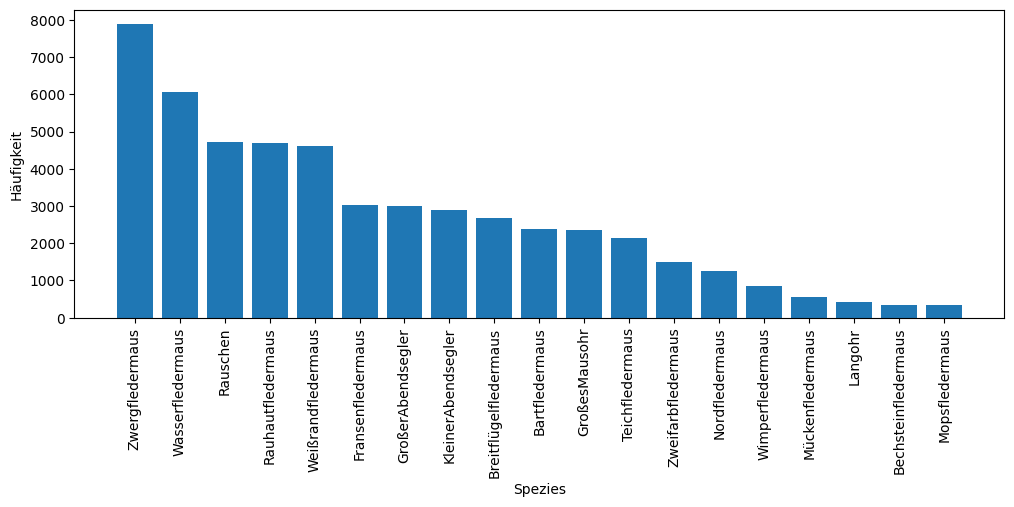

In [4]:
%matplotlib inline
sorted_bats = bat_names.sort_values(by='number', ascending=False)
fig, ax = plt.subplots(figsize=(12,4))
plt.bar(sorted_bats['bat'],sorted_bats['number'])
plt.xticks(rotation=90)
plt.ylabel("Häufigkeit")
plt.xlabel("Spezies")
plt.show()

Wir haben einen Datensatz mit 51719 Einträgen mit folgenden Attributen:
- call: wahrscheinlich Nummerierung der Aufnahmen
- target: numerische Codierung der Klasse
- id: Tabellen-spezifische ID
- bat: nominaler Wert von Target (Bezeichnung der Fledermaus)
- arr: Aufnahmen der Jagdrufe
- db: ?

Insgesamt sind 18 verschiedene Fledermausarten und Rauschen aufgenommen worden. Die Arten sind eher ungleich verteilt.

Wir werden im Folgenden die sechs am häufigsten vorkommenden Fledermäuse und das Rauschen verwenden, um verschiedene Modelle auszuprobieren.

In [5]:
our_bats = bat_names.sort_values(by='number', ascending=False).head(7)
our_bats

,bat,number
18,Zwergfledermaus,7885
14,Wasserfledermaus,6074
12,Rauschen,4713
11,Rauhautfledermaus,4695
15,Weißrandfledermaus,4619
3,Fransenfledermaus,3040
4,GroßerAbendsegler,3005


In [6]:
targets = list(our_bats.index)

In [7]:
targets

[18, 14, 12, 11, 15, 3, 4]

## Data Collection and Preprocessing

In [8]:
import librosa
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import io
import sqlite3
import os
from scipy.signal import butter, lfilter

In [9]:
def _convert_array(text):
	out = io.BytesIO(text)
	out.seek(0)
	return np.load(out, allow_pickle=True)
    
def _adapt_array(arr):
	out = io.BytesIO()
	np.save(out, arr)
	out.seek(0)
	return sqlite3.Binary(out.read())
    
def butter_bandpass(lowcut, highcut, fs, order=5):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
  b, a = butter_bandpass(lowcut, highcut, fs, order=order)
  y = lfilter(b, a, data)
  return y

def make_sets(data_rows, targets):
  spec_list = []
  label_list = []
  for row in data_rows:
    #target_class = targets.index(row[1])
    target_class = row[1]
    call = row[4].astype(np.float32, order='C') / 32768.0

    # Bandpass to filter low and high frequencies
    data_bp = butter_bandpass_filter(call, 1500, 12000, 44100, 5)

    # Normalize
    data_bp -= np.mean(data_bp)
    data_bp /= np.std(data_bp)

    # Calculate spectrogram with FFT
    stft = np.abs(librosa.stft(data_bp, n_fft=512, hop_length=32))
    stft = 10 * np.log10(stft)
    stft = np.nan_to_num(stft)

    # Scale between [0,1] and reduce shape if needed
    stft = (stft - np.min(stft)) / (np.max(stft) - np.min(stft))
    stft = np.reshape(stft, (257, 138, 1))
    stft = stft[:256, -128: , :] #Größe der Spektrogramme festlegen?

    spec_list.append(stft)
    label_list.append(target_class)
  return spec_list, label_list

In [10]:
def load_spectrograms(data_path, num_per_class, targets) -> list:

    num_calls = num_per_class
    all_rows = []

    sqlite3.register_adapter(np.ndarray, _adapt_array)
    sqlite3.register_converter("ARRAY", _convert_array)
    
    with sqlite3.connect(db_path, detect_types=True) as con:
      cur = con.cursor()
      for target in targets:
        if num_calls > 0:
          rows = [x for x in cur.execute(f"SELECT * FROM batcalls WHERE target = {target} LIMIT {num_calls}")]
        else:
          rows = [x for x in cur.execute(f"SELECT * FROM batcalls WHERE target = {target}")]
        all_rows.extend(rows)

    spectrograms, labels = make_sets(all_rows, targets)
    return spectrograms, labels

In [11]:
X, y = load_spectrograms(data_path="./data", num_per_class=3000, targets=targets)
print(len(X))

/var/folders/5x/xl546rz52y15rf55pdkv6tg80000gn/T/ipykernel_17616/2729543777.py:41: RuntimeWarning: divide by zero encountered in log10
  stft = 10 * np.log10(stft)


21000


In [12]:
frequency = {cl : 0 for cl in y}
for cl in y:
    frequency[cl]+=1
frequency

{18: 3000, 14: 3000, 12: 3000, 11: 3000, 15: 3000, 3: 3000, 4: 3000}

In [13]:
X_3d = X.copy() #brauchen wir später für Convolution

In [14]:
X[0].shape

(256, 128, 1)

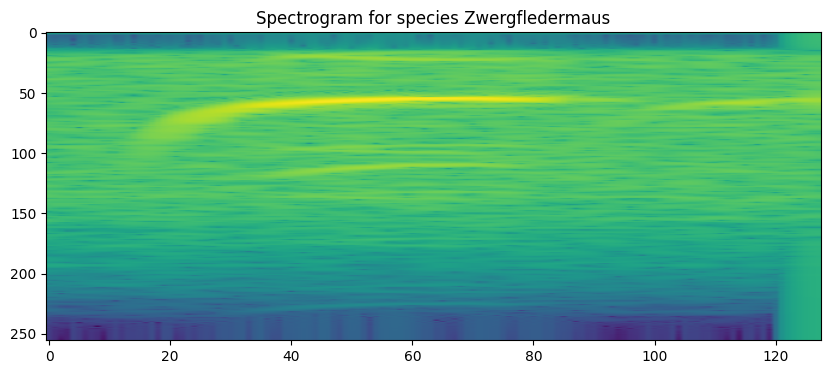

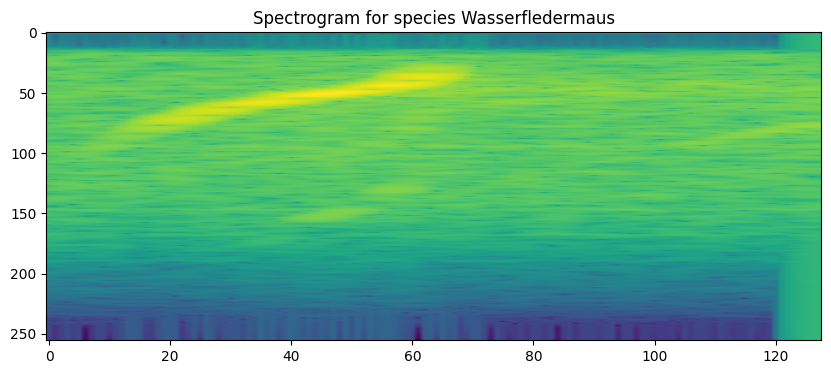

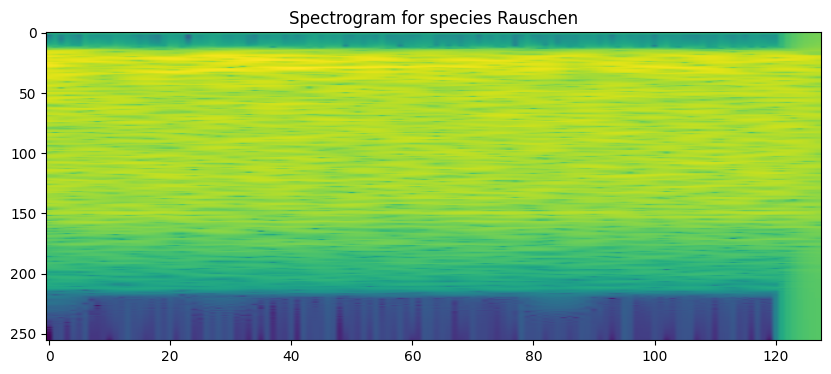

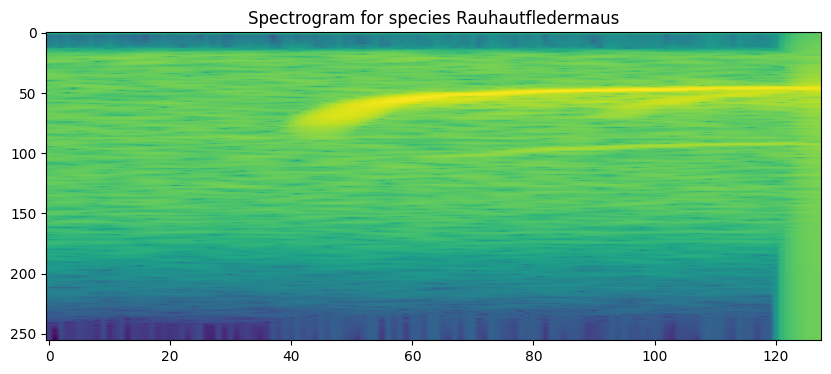

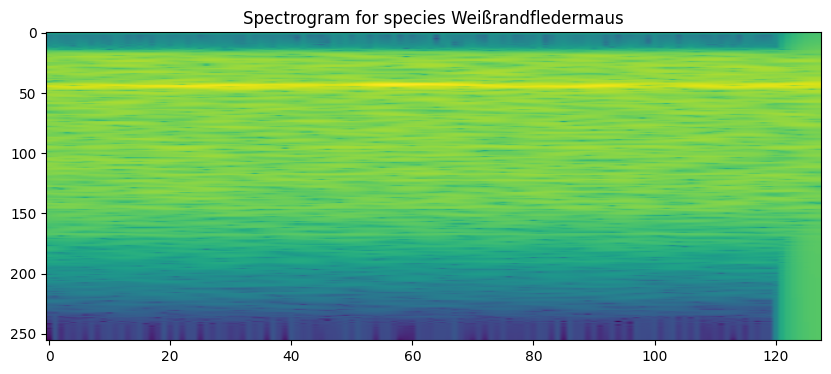

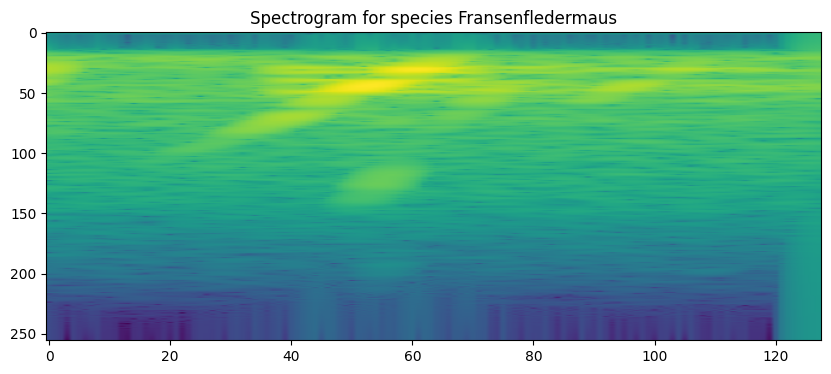

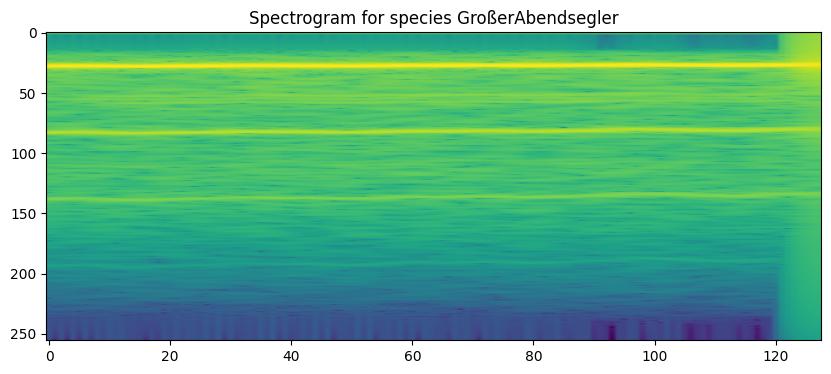

In [15]:
labels = {18: "Zwergfledermaus", 14: "Wasserfledermaus", 12: "Rauschen", 
          11: "Rauhautfledermaus", 15: "Weißrandfledermaus", 3: "Fransenfledermaus", 
          4: "GroßerAbendsegler"}

for label in labels.keys():
    i = y.index(label)
    fig, ax = plt.subplots(figsize=(10,4))
    ax.imshow(X[i][:,:,0],aspect='auto')
    plt.title("Spectrogram for species " + str(labels[(y[i])]))

In [16]:
for i in range(len(X)):
    X[i] = X[i].reshape(256,128)

In [17]:
X[3].shape

(256, 128)

## Methoden

In [18]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.utils import to_categorical  
from keras.layers import InputLayer,Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization

In [19]:
from IPython.display import clear_output

class PlotAccAndLoss(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []

        self.acc = []
        self.val_acc = []
        
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        
        self.i += 1
        
        clear_output(wait=True)
        fig, ax = plt.subplots(1,2, figsize=(12,4))
        
        ax[0].plot(self.x, self.losses, label="loss")
        ax[0].plot(self.x, self.val_losses, label="val_loss")
        ax[0].legend()

        ax[1].plot(self.x, self.acc, label="accuracy")
        ax[1].plot(self.x, self.val_acc, label="val_accuracy")
        ax[1].legend()

        plt.show();
        
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();

class PlotAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.val_acc = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.acc, label="accuracy")
        plt.plot(self.x, self.val_acc, label="val_accuracy")
        plt.legend()
        plt.show();

plot_acc_loss = PlotAccAndLoss()
plot_losses = PlotLosses()
plot_accuracy = PlotAccuracy()
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)


#### CNN

In [20]:
X_3d = np.array(X_3d)
    
X_3d.shape

(21000, 256, 128, 1)

In [21]:
train_img, test_img, train_labels, test_labels = train_test_split(X_3d, y, 
                                                    test_size=0.2, random_state=0)
y_dict = {18: 0, 14: 1, 12: 2, 11: 3, 15: 4, 3: 5, 4: 6}
train_labels = [y_dict[lab] for lab in train_labels]
test_labels  = [y_dict[lab] for lab in test_labels]

y_train = to_categorical(train_labels, num_classes=len(our_bats))
y_test = to_categorical(test_labels, num_classes=len(our_bats))

X_train = train_img.astype('float32')
X_test = test_img.astype('float32')

In [22]:
y_train.shape

(16800, 7)

In [23]:
len(our_bats)

7

#### Model 1

In [24]:
conv_model = Sequential()
conv_model.add(Conv2D(60, 
                      kernel_size=(3,3),
                      strides=(1,1), 
                      padding='same',
                      activation='relu', 
                      input_shape=(X_3d[0].shape)))
conv_model.add(MaxPooling2D(pool_size=(3,3), 
                            strides=(1,1)))
conv_model.add(Conv2D(30, 
                      kernel_size=(3,3),
                      strides=(1,1), 
                      padding='same',
                      activation='relu'))
conv_model.add(MaxPooling2D(pool_size=(3, 3),
                           strides=(1,1)))
conv_model.add(Flatten())
conv_model.add(Dense(64, activation='relu'))
conv_model.add(Dense(len(our_bats), activation='softmax'))      

adam_opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
conv_model.compile(
    optimizer=adam_opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

<Figure size 640x480 with 0 Axes>

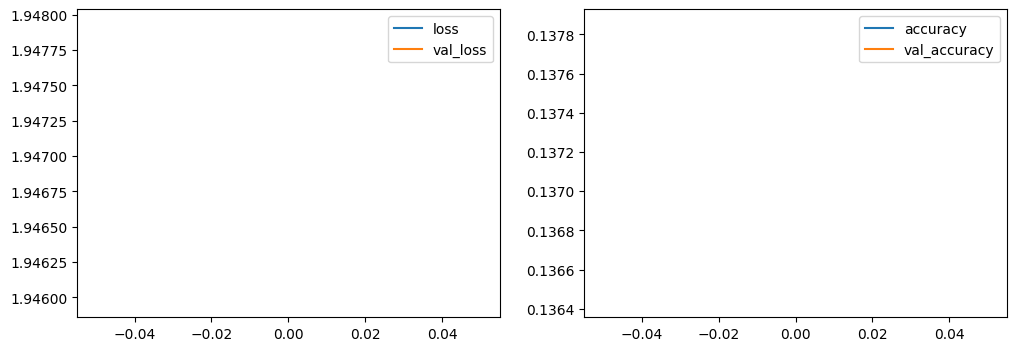

3360/3360 ━━━━━━━━━━━━━━━━━━━━ 631s 187ms/step - accuracy: 0.1379 - loss: 1.9479 - val_accuracy: 0.1364 - val_loss: 1.9460
Epoch 2/20
 286/3360 ━━━━━━━━━━━━━━━━━━━━ 9:20 182ms/step - accuracy: 0.1284 - loss: 1.9459

KeyboardInterrupt: 

In [ ]:
history_conv_model=conv_model.fit(X_train, y_train,
                                  validation_data=(X_test, y_test),                              
                                  epochs=50,
                                  batch_size=32,
                                  callbacks=[plot_acc_loss, EarlyStopping])

### Using Keras Tuner

This will need some time ...

In [ ]:
import keras_tuner as kt

class hypermodel(kt.HyperModel):
    def build(self,hp):
        model = Sequential()
        model.add(Conv2D(
            filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
            kernel_size=(3,3),
            strides=(1,1), 
            padding='same',
            activation='relu', 
            input_shape=(256, 128, 1)
        ))
        model.add(MaxPooling2D(pool_size=(2,2)))
        if hp.Boolean('use_second_conv'):
            model.add(Conv2D(
                filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
                kernel_size=(3,3),
                strides=(1,1), 
                padding='same',
                activation='relu'
            ))
            model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Flatten())
        model.add(Dense(
            units=hp.Int('dense_units', min_value=64, max_value=512, step=64),
            activation='relu'
        ))
        model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(7, activation='softmax'))

        model.compile(
            optimizer=keras.optimizers.Adam(
                learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model
    
    def fit(self, hp, model, X, y, **kwargs):
        return model.fit(
            X, y,
            batch_size=hp.Choice("batch_size", values=[8, 64, 256]),
            **kwargs
        )

tuner = kt.Hyperband(
    hypermodel(),
    objective='val_accuracy',
    max_epochs = 30,
    factor=3,             
    directory='tuner_results',
    project_name='bat_classification_hyperband',
)

tuner.search(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[EarlyStopping]
)


Trial 44 Complete [00h 18m 42s]
val_accuracy: 0.7950000166893005

Best val_accuracy So Far: 0.8647618889808655
Total elapsed time: 11h 48m 49s

Search: Running Trial #45

Value             |Best Value So Far |Hyperparameter
64                |32                |conv1_filters
True              |True              |use_second_conv
448               |192               |dense_units
0.4               |0                 |dropout
9.8037e-05        |0.00079882        |learning_rate
64                |64                |conv2_filters
256               |8                 |batch_size
4                 |4                 |tuner/epochs
2                 |2                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
1                 |1                 |tuner/round
0006              |0002              |tuner/trial_id

Epoch 3/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5143 - loss: 1.3216

: 

### Reloading Tuner

In [23]:
import keras_tuner as kt

class hypermodel(kt.HyperModel):
    def build(self,hp):
        model = Sequential()
        model.add(Conv2D(
            filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
            kernel_size=(3,3),
            strides=(1,1), 
            padding='same',
            activation='relu', 
            input_shape=(256, 128, 1)
        ))
        model.add(MaxPooling2D(pool_size=(2,2)))
        if hp.Boolean('use_second_conv'):
            model.add(Conv2D(
                filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
                kernel_size=(3,3),
                strides=(1,1), 
                padding='same',
                activation='relu'
            ))
            model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Flatten())
        model.add(Dense(
            units=hp.Int('dense_units', min_value=64, max_value=512, step=64),
            activation='relu'
        ))
        model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(7, activation='softmax'))

        model.compile(
            optimizer=keras.optimizers.Adam(
                learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model
    
    def fit(self, hp, model, X, y, **kwargs):
        return model.fit(
            X, y,
            batch_size=hp.Choice("batch_size", values=[8, 64, 256]),
            **kwargs
        )

tuner = kt.Hyperband(
    hypermodel(),
    objective='val_accuracy',
    max_epochs = 30,
    factor=3,             
    directory='tuner_results',
    project_name='bat_classification_hyperband',
)

tuner.reload()

Reloading Tuner from tuner_results/bat_classification_hyperband/tuner0.json


In [25]:
best_hps = tuner.get_best_hyperparameters(num_trials=3)

for i in range(len(best_hps)):
    print(f"Best hyperparameters for trial {i+1}:")
    for param in best_hps[i].values:
        print(f"  {param}: {best_hps[i].get(param)}")
    print()

Best hyperparameters for trial 1:
  conv1_filters: 32
  use_second_conv: True
  dense_units: 192
  dropout: 0.0
  learning_rate: 0.0007988181882078144
  conv2_filters: 64
  batch_size: 8
  tuner/epochs: 4
  tuner/initial_epoch: 2
  tuner/bracket: 3
  tuner/round: 1
  tuner/trial_id: 0002

Best hyperparameters for trial 2:
  conv1_filters: 96
  use_second_conv: False
  dense_units: 512
  dropout: 0.0
  learning_rate: 0.0014940366732453544
  conv2_filters: 32
  batch_size: 8
  tuner/epochs: 4
  tuner/initial_epoch: 2
  tuner/bracket: 3
  tuner/round: 1
  tuner/trial_id: 0004

Best hyperparameters for trial 3:
  conv1_filters: 32
  use_second_conv: True
  dense_units: 320
  dropout: 0.1
  learning_rate: 0.0007482080579115888
  conv2_filters: 64
  batch_size: 64
  tuner/epochs: 4
  tuner/initial_epoch: 2
  tuner/bracket: 3
  tuner/round: 1
  tuner/trial_id: 0001



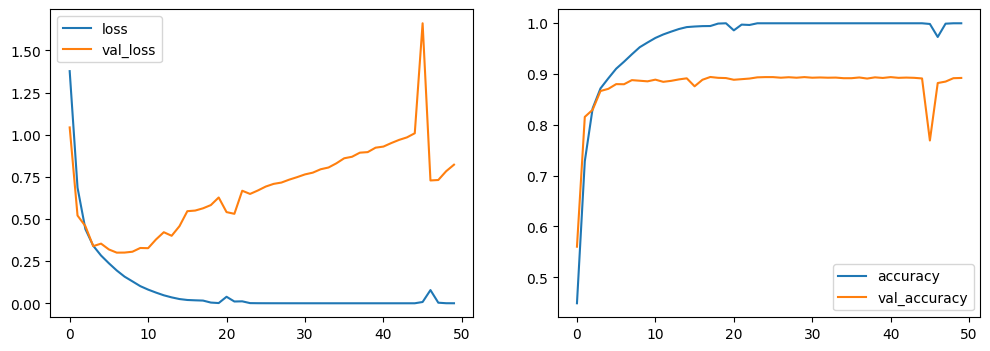


Epoch 50: val_accuracy did not improve from 0.89429
525/525 ━━━━━━━━━━━━━━━━━━━━ 90s 171ms/step - accuracy: 1.0000 - loss: 1.1924e-04 - val_accuracy: 0.8924 - val_loss: 0.8224


In [26]:
model = tuner.hypermodel.build(best_hps[0])
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_accuracy",      # oder "accuracy"
    save_best_only=True,
    mode="max",
    verbose=1
)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=50,callbacks=[plot_acc_loss, EarlyStopping, checkpoint])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 64, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 64, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 192)            │    25,166,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,351 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,558,551 (288.23 MB)

 Trainable params: 25,186,183 (96.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,372,368 (192.16 MB)

132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step
132/132 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8943 - loss: 0.5635
Test Accuracy: 0.8943
Test Loss: 0.5635


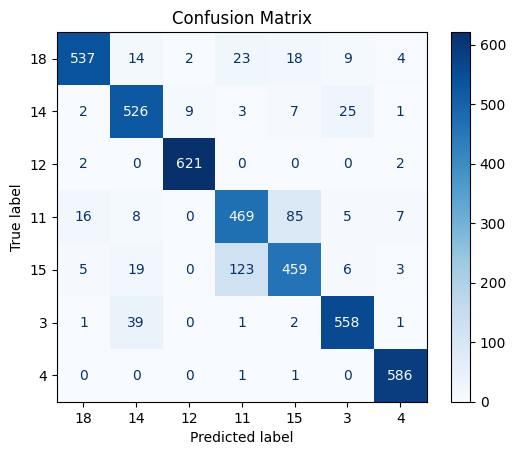

In [ ]:
model = keras.models.load_model("best_model.keras")
model.summary()
predictions = model.predict(X_test)
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

#konfusionsmatrix
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [32]:
our_bats

,bat,number
18,Zwergfledermaus,7885
14,Wasserfledermaus,6074
12,Rauschen,4713
11,Rauhautfledermaus,4695
15,Weißrandfledermaus,4619
3,Fransenfledermaus,3040
4,GroßerAbendsegler,3005
